In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from LDGD.model import ARDRBFKernel, LDGD
from LDGD.model.experimental.GP_scratch import bGPLVM
from LDGD.visualization import plot_box_plots
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.mlls import VariationalELBO
import gpytorch
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt


In [3]:
np.random.seed(42)
torch.manual_seed(42)

duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Settings

In [4]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points': 5,
    'num_epochs_train': 5000,
    'num_epochs_test': 5000,
    'batch_size': 200,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'n_features': 10
}

# Load Oil dataset

In [5]:
train_data_oil = np.load('../data/train_data.npy', allow_pickle=True)
test_data_oil = np.load('../data/test_data.npy', allow_pickle=True)

yn_train_oil, ys_train_oil, labels_train_oil = train_data_oil.take(0)['yn_train'], train_data_oil.take(0)['ys_train'], train_data_oil.take(0)['labels_train']
yn_test_oil, ys_test_oil, labels_test_oil = test_data_oil.take(0)['yn_test'], test_data_oil.take(0)['ys_test'], test_data_oil.take(0)['labels_test']

yn_train_oil, ys_train_oil, labels_train_oil = torch.Tensor(yn_train_oil), torch.Tensor(ys_train_oil), torch.Tensor(labels_train_oil)
yn_test_oil, ys_test_oil, labels_test_oil = torch.Tensor(yn_test_oil), torch.Tensor(ys_test_oil), torch.Tensor(labels_test_oil)

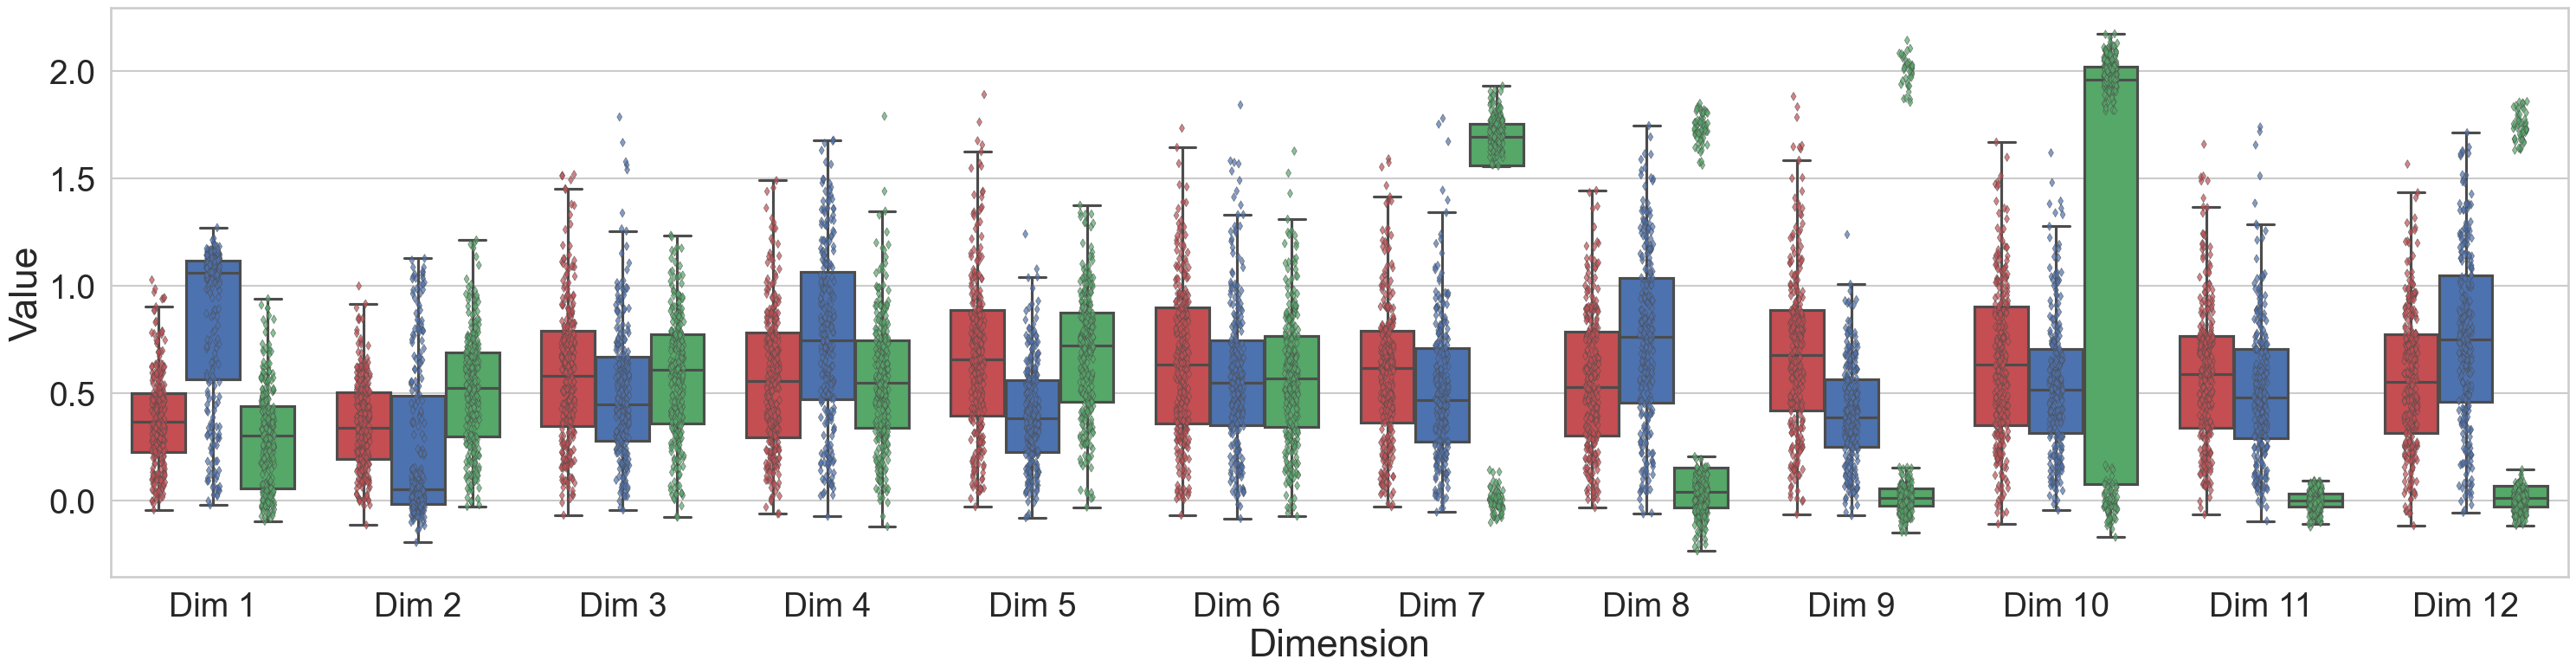

In [6]:
plot_box_plots(data=yn_train_oil, labels=labels_train_oil, save_path='saved_results/', file_name='box_plot_oil_flow')


# Load IRIS dataset

In [7]:
train_data_iris = np.load('../data/train_data_iris.npy', allow_pickle=True)
test_data_iris = np.load('../data/test_data_iris.npy', allow_pickle=True)

yn_train_iris, ys_train_iris, labels_train_iris = train_data_iris.take(0)['yn_train'], train_data_iris.take(0)['ys_train'], train_data_iris.take(0)['labels_train']
yn_test_iris, ys_test_iris, labels_test_iris = test_data_iris.take(0)['yn_test'], test_data_iris.take(0)['ys_test'], test_data_iris.take(0)['labels_test']

yn_train_iris, ys_train_iris, labels_train_iris = torch.Tensor(yn_train_iris), torch.Tensor(ys_train_iris), torch.Tensor(labels_train_iris)
yn_test_iris, ys_test_iris, labels_test_iris = torch.Tensor(yn_test_iris), torch.Tensor(ys_test_iris), torch.Tensor(labels_test_iris)

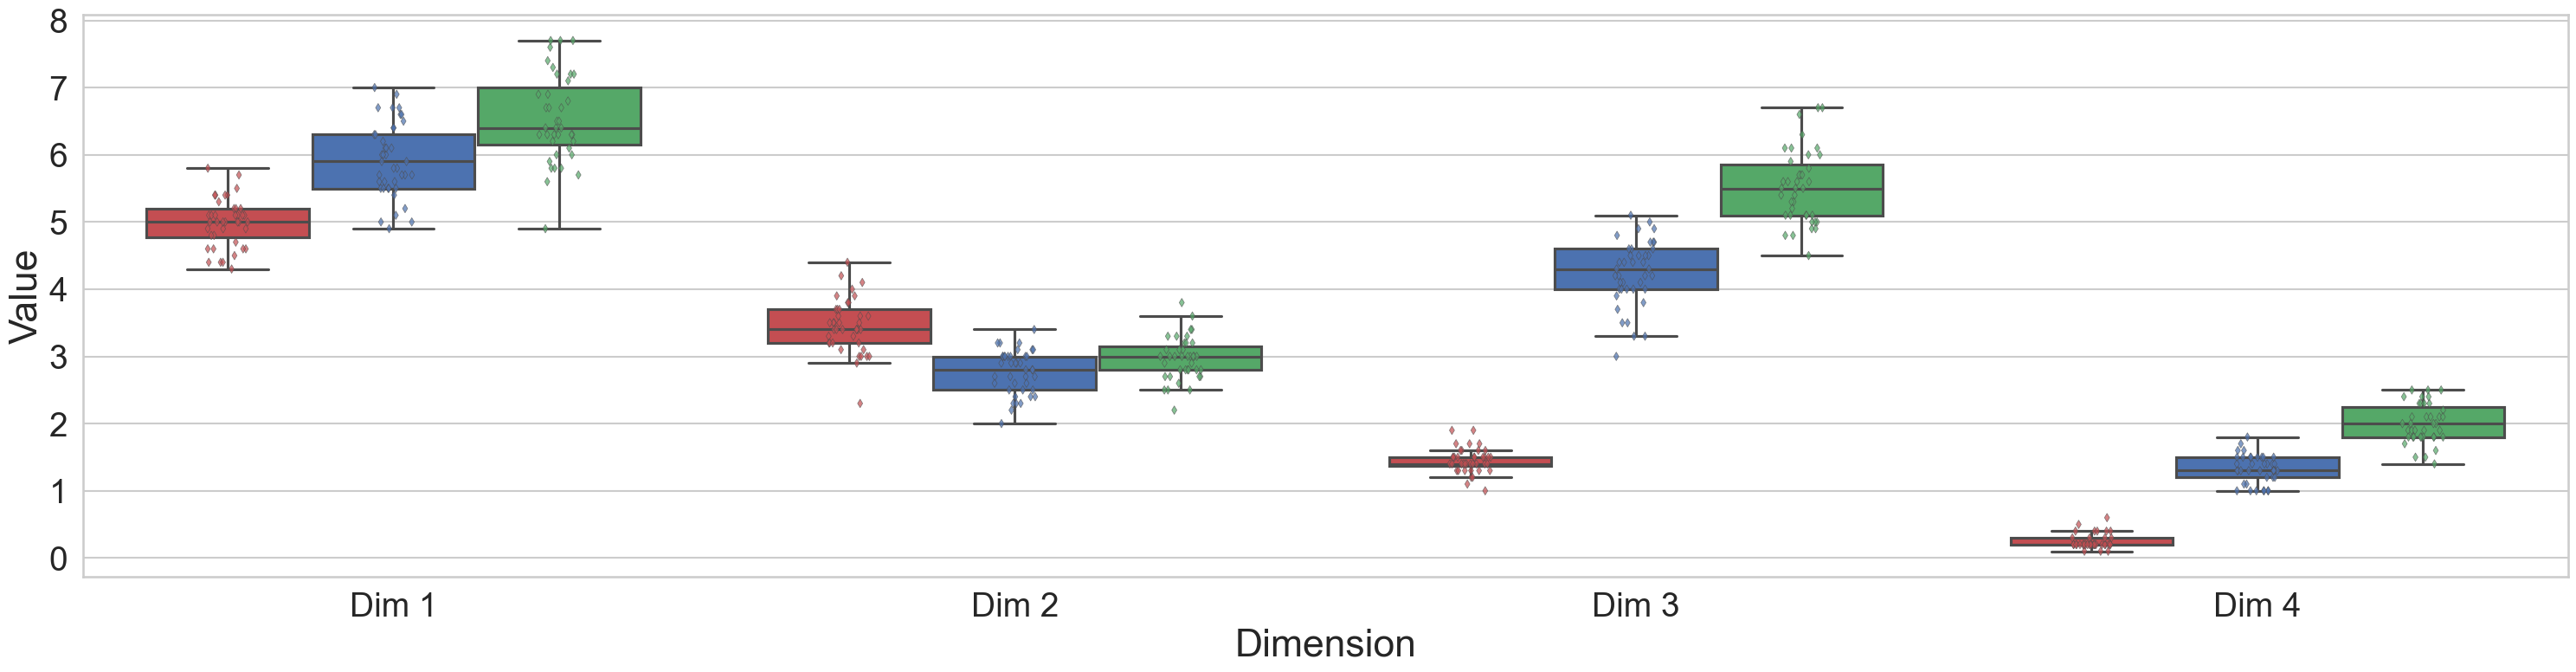

In [8]:
plot_box_plots(data=yn_train_iris, labels=labels_train_iris, save_path='saved_results/', file_name='box_plot_iris')


# PCA

In [9]:
X_pca_oil = PCA(n_components=2).fit_transform(yn_train_oil)
X_pca_iris = PCA(n_components=2).fit_transform(yn_train_iris)

# T-SNE

In [10]:
try:
    x_tsne_oil = np.load('../data/x_tsne_oil.npy')
except:
    x_tsne_oil = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(yn_train_oil)
    np.save('../data/x_tsne_iris.npy', x_tsne_oil)

try:
    x_tsne_iris = np.load('../data/x_tsne_iris.npy')
except:
    x_tsne_iris = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(yn_train_iris)
    np.save('../data/x_tsne_iris.npy', x_tsne_iris)


# GPLVM - Point Estimate

In [11]:
try:
    x_param_gplvm_iris = np.load('../data/x_param_gplvm_iris.npy')
except:
    num_points, data_dim = yn_train_iris.shape
    model = bGPLVM(num_points, data_dim, model_settings['latent_dim'], model_settings['num_inducing_points'], mode='point_estimate')

    # Likelihood
    likelihood = GaussianLikelihood(batch_shape=model.batch_shape)
    mll = VariationalELBO(likelihood, model, num_data=len(yn_train_iris))

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}], lr=0.01)

    loss_list = model.train_model(yn_train_iris, optimizer, mll, epochs=3000)

    x_param_gplvm_iris = model.X.X.detach().numpy()
    np.save('../data/x_param_gplvm_iris.npy', x_param_gplvm_iris)

In [12]:
try:
    x_param_gplvm_oil = np.load('../data/x_param_gplvm_oil.npy')
except:
    num_points, data_dim = yn_train_oil.shape
    model = bGPLVM(num_points, data_dim, model_settings['latent_dim'], model_settings['num_inducing_points'], mode='point_estimate')

    # Likelihood
    likelihood = GaussianLikelihood(batch_shape=model.batch_shape)
    mll = VariationalELBO(likelihood, model, num_data=len(yn_train_oil))

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}], lr=0.01)

    loss_list = model.train_model(yn_train_oil, optimizer, mll, epochs=3000)

    x_param_gplvm_oil = model.X.X.detach().numpy()
    np.save('../data/x_param_gplvm_oil.npy', x_param_gplvm_oil)

# Baysian GPLVM

In [13]:
try:
    x_bayesian_gplvm_oil = np.load('../data/x_bayesian_gplvm_oil.npy')
except:
    num_points, data_dim = yn_train_oil.shape
    model = bGPLVM(num_points, data_dim, model_settings['latent_dim'], model_settings['num_inducing_points'], mode='bayesian')

    # Likelihood
    likelihood = GaussianLikelihood(batch_shape=model.batch_shape)
    mll = VariationalELBO(likelihood, model, num_data=len(yn_train_oil))

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}], lr=0.01)

    loss_list = model.train_model(yn_train_oil, optimizer, mll, epochs=5000)

    # vISUALIZATION
    x_bayesian_gplvm_oil = model.X.q_mu.detach().numpy()
    np.save('../data/x_bayesian_gplvm_oil.npy', x_bayesian_gplvm_oil)

In [14]:
try:
    x_bayesian_gplvm_iris = np.load('../data/x_bayesian_gplvm_iris.npy')
except:
    num_points, data_dim = yn_train_iris.shape
    model = bGPLVM(num_points, data_dim, model_settings['latent_dim'], model_settings['num_inducing_points'], mode='bayesian')

    # Likelihood
    likelihood = GaussianLikelihood(batch_shape=model.batch_shape)
    mll = VariationalELBO(likelihood, model, num_data=len(yn_train_iris))

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}], lr=0.01)

    loss_list = model.train_model(yn_train_iris, optimizer, mll, epochs=5000)

    # vISUALIZATION
    x_bayesian_gplvm_iris = model.X.q_mu.detach().numpy()
    np.save('../data/x_bayesian_gplvm_iris.npy', x_bayesian_gplvm_iris)

# Shared GPLVM (DGPLVM)

In [15]:
results_sgplvm_oil = loadmat("../data/result_sgplvm_oil.mat")
x_sgplvm_oil = results_sgplvm_oil['latent_z']

results_sgplvm_iris = loadmat("../data/result_sgplvm_iris.mat")
x_sgplvm_iris = results_sgplvm_iris['latent_z']

# SLLGPLVM

In [16]:
results_sllgplvm_oil = loadmat("../data/result_sllgplvm.mat")
x_sllgplvm_oil = results_sllgplvm_oil['zz']

results_sllgplvm_iris = loadmat("../data/result_sllgplvm_iris.mat")
x_sllgplvm_iris = results_sllgplvm_iris['z']

# Fast GPLVM

In [17]:
results_fgplvm_oil = loadmat("../data/result_fgplvm.mat")
x_fgplvm_oil = results_fgplvm_oil['z']

results_fgplvm_iris = loadmat("../data/result_fgplvm_iris.mat")
x_fgplvm_iris = results_fgplvm_iris['z']

# LDGD

In [18]:
try:
    x_ldgd_oil = np.load('../data/x_dbgplvm_oil.npy')
except:
    num_points, data_dim = yn_train_oil.shape
    batch_shape = torch.Size([data_dim])
    model_settings['use_gpytorch'] = True
    if model_settings['use_gpytorch'] is False:
        kernel_cls = ARDRBFKernel(input_dim=model_settings['latent_dim'])
        kernel_reg = ARDRBFKernel(input_dim=model_settings['latent_dim'])
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()

    model = LDGD(yn_train_oil,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=ys_train_oil.shape[-1],
                latent_dim=model_settings['latent_dim'],
                num_inducing_points=model_settings['num_inducing_points'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=model_settings['use_gpytorch'],
                shared_inducing_points=True,
                use_shared_kernel=False)

    losses, x_mu_list, x_sigma_list = model.train_model(yn=yn_train_oil,
                                                        ys=ys_train_oil,
                                                        epochs=model_settings['num_epochs_train'],
                                                        batch_size=model_settings['batch_size'])

    x_ldgd_oil = model.x.q_mu.detach().numpy()
    np.save('../data/x_ldgd_oil.npy', x_ldgd_oil)

In [19]:
try:
    x_ldgd_iris = np.load('../data/x_dbgplvm_iris.npy')
except:
    num_points, data_dim = yn_train_iris.shape
    batch_shape = torch.Size([data_dim])
    model_settings['use_gpytorch'] = True
    if model_settings['use_gpytorch'] is False:
        kernel_cls = ARDRBFKernel(input_dim=model_settings['latent_dim'])
        kernel_reg = ARDRBFKernel(input_dim=model_settings['latent_dim'])
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=model_settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()

    model = LDGD(yn_train_iris,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=ys_train_iris.shape[-1],
                latent_dim=model_settings['latent_dim'],
                num_inducing_points=model_settings['num_inducing_points'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=model_settings['use_gpytorch'],
                shared_inducing_points=True,
                use_shared_kernel=False)

    losses, x_mu_list, x_sigma_list = model.train_model(yn=yn_train_iris,
                                                        ys=ys_train_iris,
                                                        epochs=model_settings['num_epochs_train'],
                                                        batch_size=model_settings['batch_size'])

    x_ldgd_iris = model.x.q_mu.detach().numpy()
    np.save('../data/x_ldgd_iris.npy', x_ldgd_iris)

# Visualization

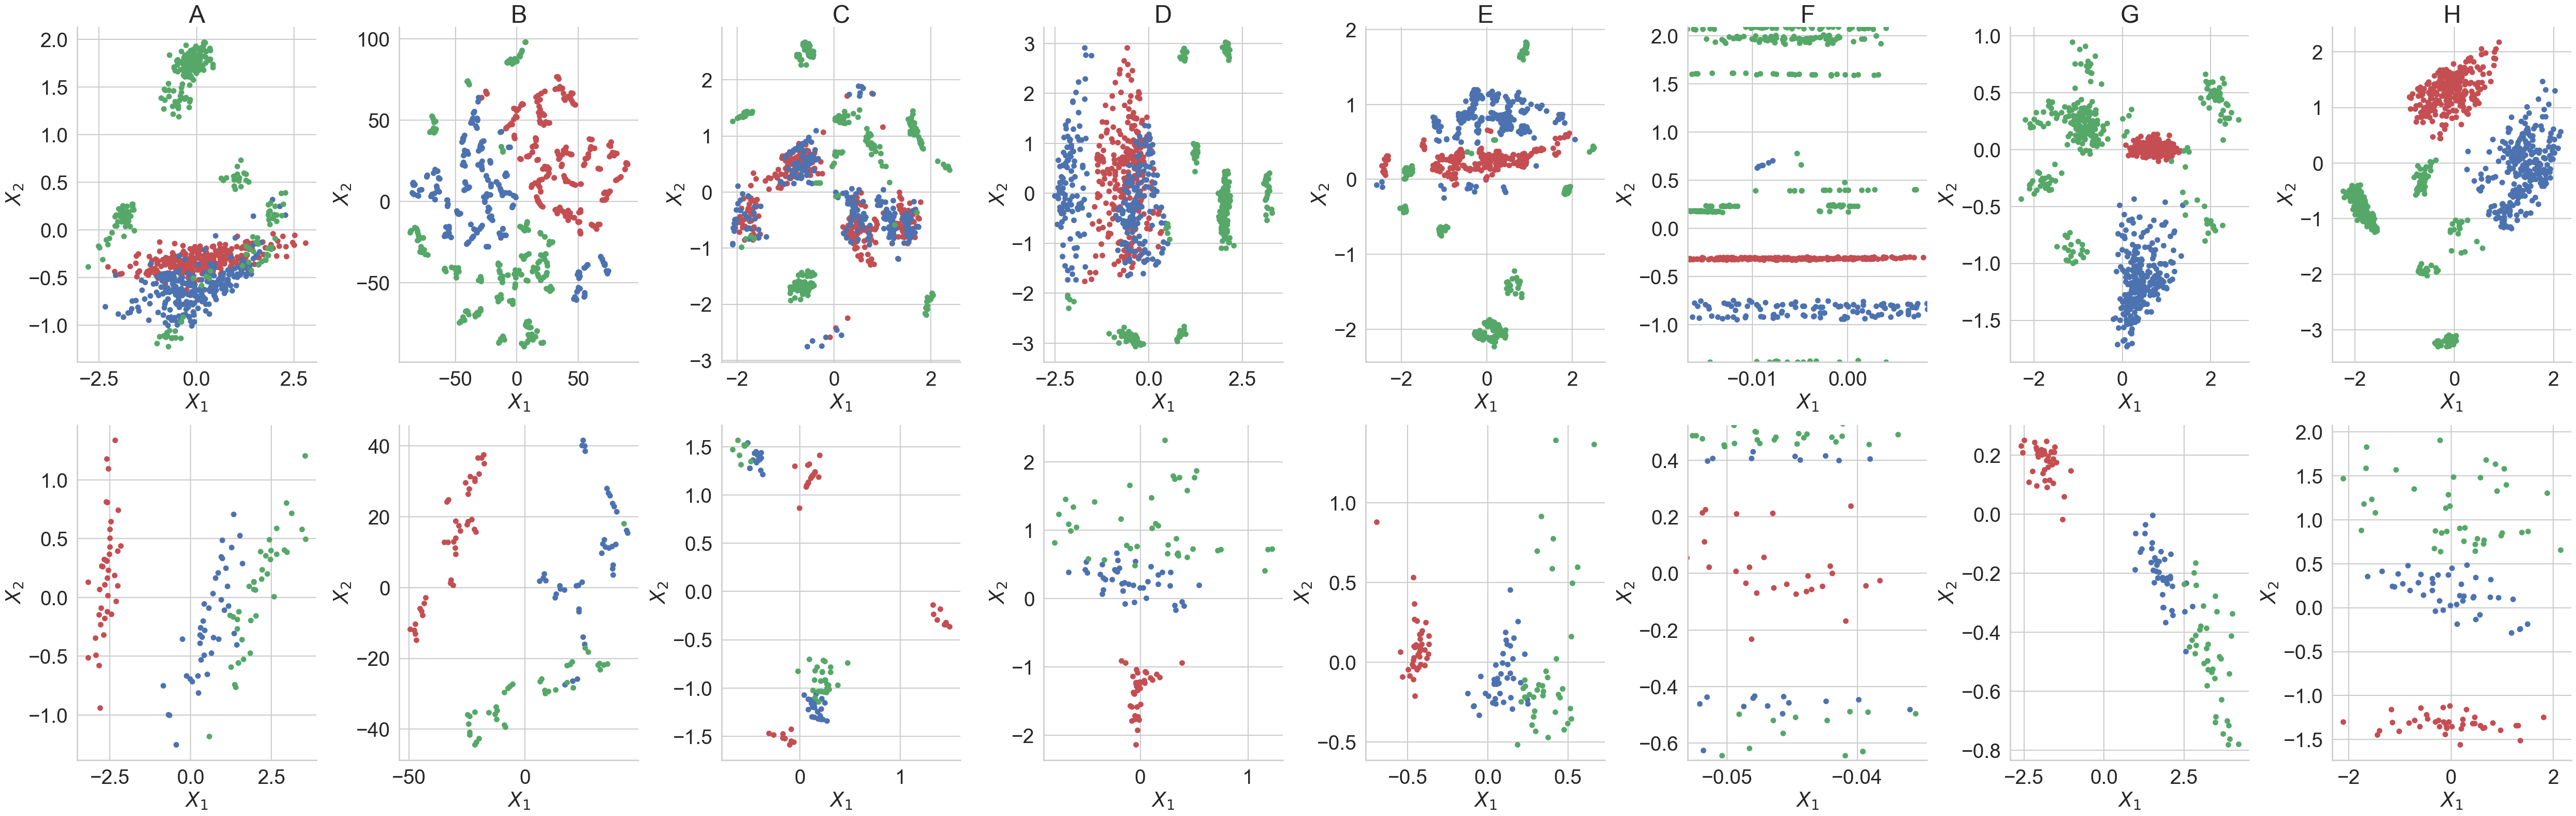

In [20]:


fig, ax = plt.subplots(2, 8, figsize=(50, 16))
fontsize = 28  # Variable for consistent font size

color_list = ['r', 'b', 'g']
label_list = ['class 1', 'class 2', 'class 3']  # Assuming there's a typo in your original label list
titles_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]


# Plotting data
for i in range(3):
    ax[0, 0].scatter(X_pca_oil[labels_train_oil == i, 0], X_pca_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 1].scatter(x_tsne_oil[labels_train_oil == i, 0], x_tsne_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 2].scatter(x_param_gplvm_oil[labels_train_oil == i, 0], x_param_gplvm_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 3].scatter(x_bayesian_gplvm_oil[labels_train_oil == i, 0], x_bayesian_gplvm_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 4].scatter(x_fgplvm_oil[labels_train_oil == i, 0], x_fgplvm_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 5].scatter(x_sgplvm_oil[labels_train_oil == i, 0], x_sgplvm_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 5].set_xlim([np.quantile(x_sgplvm_oil[labels_train_oil == i, 0], 0.02),
                       np.quantile(x_sgplvm_oil[labels_train_oil == i, 0], 0.98)])
    ax[0, 5].set_ylim([np.quantile(x_sgplvm_oil[labels_train_oil == i, 1], 0.02),
                       np.quantile(x_sgplvm_oil[labels_train_oil == i, 1], 0.98)])
    ax[0, 6].scatter(x_sllgplvm_oil[labels_train_oil == i, 0], x_sllgplvm_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[0, 7].scatter(x_ldgd_oil[labels_train_oil == i, 0], x_ldgd_oil[labels_train_oil == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])

    # Iris
    ax[1, 0].scatter(X_pca_iris[labels_train_iris == i, 0], X_pca_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 1].scatter(x_tsne_iris[labels_train_iris == i, 0], x_tsne_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 2].scatter(x_param_gplvm_iris[labels_train_iris == i, 0], x_param_gplvm_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 3].scatter(x_bayesian_gplvm_iris[labels_train_iris == i, 0], x_bayesian_gplvm_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 4].scatter(x_fgplvm_iris[labels_train_iris == i, 0], x_fgplvm_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 5].scatter(x_sgplvm_iris[labels_train_iris == i, 0], x_sgplvm_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 5].set_xlim([np.quantile(x_sgplvm_iris[labels_train_iris == i, 0], 0.02),
                       np.quantile(x_sgplvm_iris[labels_train_iris == i, 0], 0.98)])
    ax[1, 5].set_ylim([np.quantile(x_sgplvm_iris[labels_train_iris == i, 1], 0.02),
                       np.quantile(x_sgplvm_iris[labels_train_iris == i, 1], 0.98)])
    ax[1, 6].scatter(x_sllgplvm_iris[labels_train_iris == i, 0], x_sllgplvm_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])
    ax[1, 7].scatter(x_ldgd_iris[labels_train_iris == i, 0], x_ldgd_iris[labels_train_iris == i, 1], c=color_list[i],
                     s=40, alpha=1, edgecolor=color_list[i])


for i in range(8):
    ax[0, i].set_xlabel('$X_1$', fontsize=fontsize)
    ax[0, i].set_ylabel('$X_2$', fontsize=fontsize)
    ax[0, i].tick_params(axis='both', which='major', labelsize=fontsize)

    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)

    ax[0, i].set_title(titles_list[i], fontsize=34)
    ax[1, i].set_xlabel('$X_1$', fontsize=fontsize)
    ax[1, i].set_ylabel('$X_2$', fontsize=fontsize)
    ax[1, i].tick_params(axis='both', which='major', labelsize=fontsize)

    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("./saved_results/figure3.png")
fig.savefig("./saved_results/figure3.svg")
